## Produce digits of power

In [ ]:
# Import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint

import random
import pickle

import sklearn.datasets
import sklearn.model_selection

import sklearn.neural_network

In [3]:
# Call MNIST and keep 3s and 7s
mnist = sklearn.datasets.fetch_mldata("MNIST original")

# Rescale the data and extract all images for two digits
X, y = mnist.data / 255., mnist.target

index = np.where((mnist.target == 3) | (mnist.target == 7))[0]

X0,y = X[index], y[index]

X0_train, X0_test, y_train, y_test = sklearn.model_selection.train_test_split(X0, y, test_size=0.2)

print(X0_train.shape)

TimeoutError: [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond

In [ ]:
mlp_orig = sklearn.neural_network.MLPClassifier(activation = "relu", hidden_layer_sizes=(4,), max_iter = 500, solver='sgd', random_state=5, learning_rate = 'adaptive',verbose = 1)
mlp_orig.fit(X0_train,y_train)


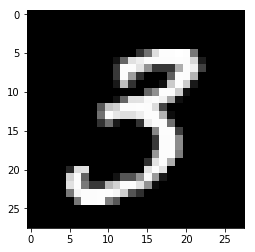

In [17]:
# A typical sampled 3
plt.imshow(X0_test[11].reshape(28,28),cmap=plt.cm.gray)
plt.show()

In [20]:
# Add simplest adversarial perturbation
delta = X0[y == 3].mean(axis=0) - X0[y == 7].mean(axis=0)
#ave = X0[y == 3].mean(axis=0)# + X0[y == 9].mean(axis=0)

eps = 0.1
X0_adv = np.zeros(X0.shape)

X0_adv[y == 3] = X0[y == 3] - eps*np.sign(delta)
X0_adv[y == 7] = X0[y == 7] + eps*np.sign(delta)

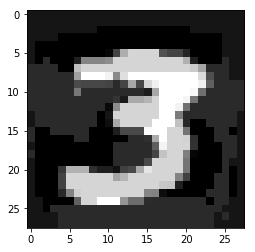

In [21]:
# A typical adversarially perturbed 3; note the background pixels.
plt.imshow(X0_adv[3].reshape(28,28),cmap=plt.cm.gray)
plt.show()

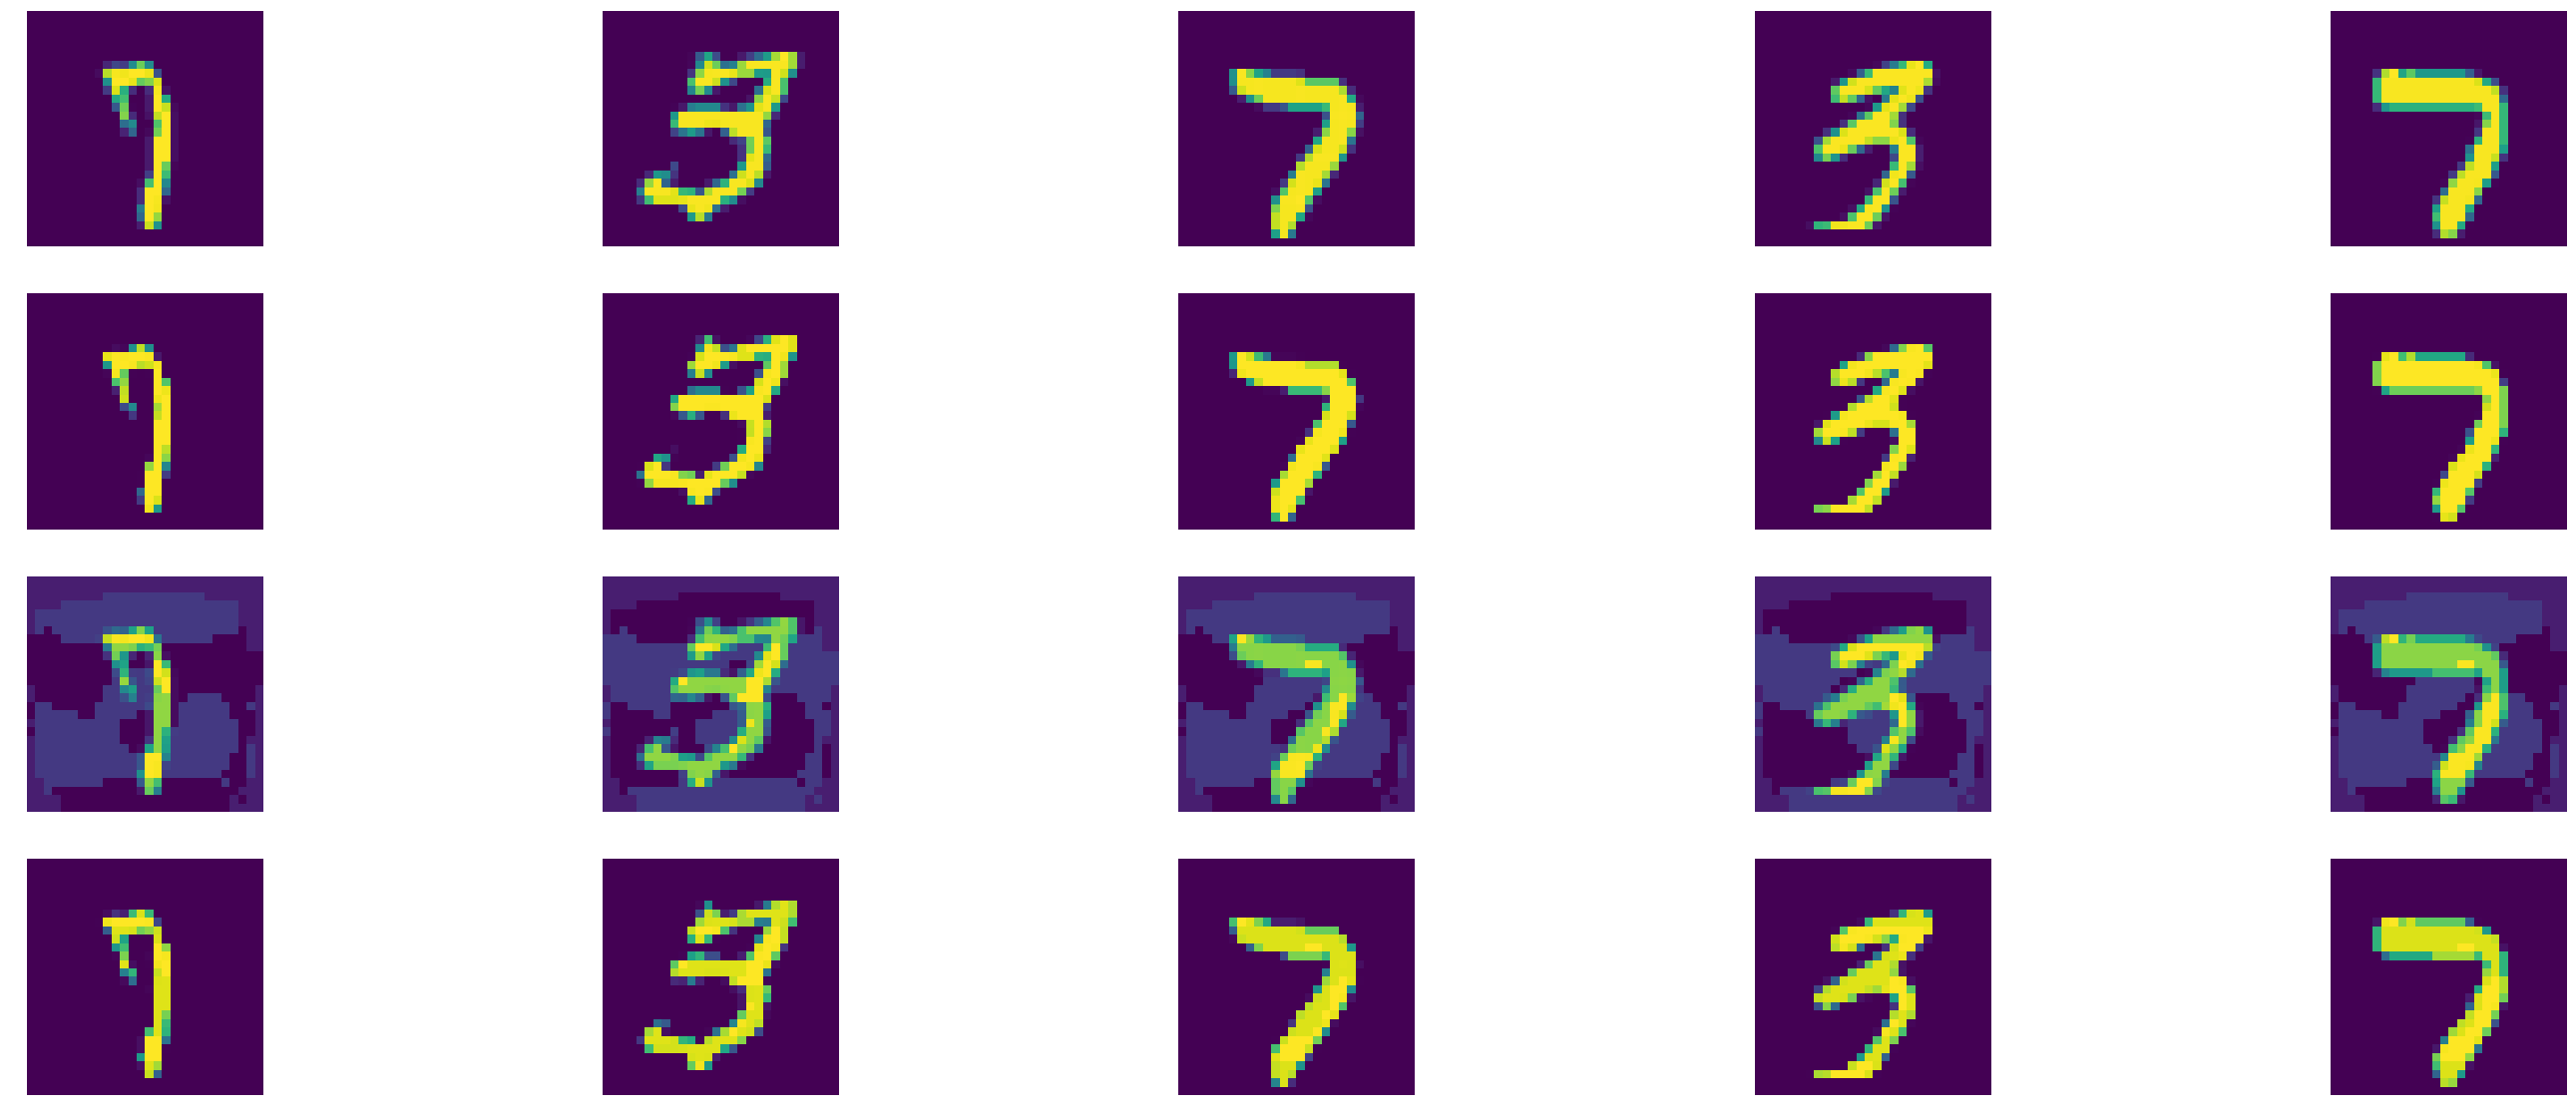

In [22]:
sample = [int(len(X0)*random.random()) for _ in range(5)]

# theta = np.arange(0.1,1,0.2)
theta = 0.5
N = 4

X1 = X0**N/(X0**N+theta**N)
X1_adv = X0_adv**N/(X0_adv**N+theta**N)

fig, axes = plt.subplots(4,len(sample),figsize = (50,20))
for i,ax in zip(sample,axes.T):
    ax[0].imshow(X0[i].reshape(28,28))
    ax[1].imshow(X1[i].reshape(28,28))
    ax[2].imshow(X0_adv[i].reshape(28,28))
    ax[3].imshow(X1_adv[i].reshape(28,28))
    [ax_row.axis('off') for ax_row in ax]
plt.show()

In [9]:
def adv_per3(X,eps,delta):
    return X - eps*np.sign(delta)
def adv_per7(X,eps,delta):
    return X + eps*np.sign(delta)

In [10]:
def hill(x,n,theta):
#     return x**n
    return x**n/(x**n + theta**n)

In [11]:
X0_adv_test = np.zeros(X0_test.shape)
theta = 0.5
epsilon = np.arange(0,0.5,0.01)
Ns = np.arange(11)
score = np.zeros((len(Ns),len(epsilon)))
for idx_eps,eps in enumerate(epsilon):
    X0_adv_test[y_test == 3] = adv_per3(X0_test[y_test == 3],eps,delta)
    X0_adv_test[y_test == 7] = adv_per7(X0_test[y_test == 7],eps,delta)
    for idx_N,N in enumerate(Ns):
        X1_adv_test = hill(X0_adv_test,N,theta)
        score[idx_N,idx_eps]=mlp_orig.score(X1_adv_test,y_test)

In [ ]:
fig,ax = plt.subplots()
for line in score[range(2,12,2),:]:
    ax.plot(epsilon,line)
    ax.set_title(r"Even powers; $\theta$ = %.1f"%theta)
    ax.set_xlabel("Epsilon")
    ax.set_ylabel("Accuracy")
    plt.legend([2,4,6,8,10], title = "       N")
    plt.savefig("../Figures/Even-powers.png")
    
fig,ax = plt.subplots()
for line in score[range(1,11,2),:]:
    ax.plot(epsilon,line)
    ax.set_title(r"Odd powers; $\theta$ = %.1f"%theta)
    ax.set_xlabel("Epsilon")
    ax.set_ylabel("Accuracy")
    plt.legend(range(1,11,2), title = "        N")
    plt.savefig("../Figures/Odd-powers.png")

plt.show()

In [ ]:
score_naive = np.zeros((len(epsilon),1))
for idx_eps,eps in enumerate(epsilon):
    X0_adv_test[y_test == 3] = adv_per3(X0_test[y_test == 3],eps,delta)
    X0_adv_test[y_test == 7] = adv_per7(X0_test[y_test == 7],eps,delta)
    score_naive[idx_eps]=mlp_orig.score(X0_adv_test,y_test)

In [ ]:
for line in score_naive.T:
    plt.plot(epsilon,line)
    plt.title("Naive adversarial perturbation")
    plt.legend(["No transformation"])
plt.show()

## Compute gradient manually

In [10]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [11]:
def relu(x):
    for i in range(len(x)):
        x[i] = np.max((0,x[i]))
    return x

In [12]:
def hill(x,n,theta):
#     return x**n
    return x**n/(x**n + theta**n)

In [13]:
def score(x,use_hill,N,theta,mlp):
    W = mlp.coefs_
    b = mlp.intercepts_
    if use_hill:
        y = hill(x,N,theta)
    else:
        y = x[:]
    return sigmoid(np.dot(relu(np.dot(y,W[0])+b[0]),W[1])+b[1])

In [14]:
def grad_score(x,use_hill,N,theta,mlp):
    grad = np.zeros(x.shape)
    for i in range(len(x)):
        yp = x.copy(); yp[i] += 10/255; 
        ym = x.copy(); ym[i] -= 10/255;
        grad[i] = 255/2*(score(yp,use_hill,N,theta,mlp)-score(ym,use_hill,N,theta,mlp))
    return grad

In [15]:
def iter_grad(x0,use_hill,N,theta,mlp,eps):
    num_iter = 0; 
    x = x0.copy()
    pred = mlp.predict(x0.reshape(1,-1))
    new_pred = mlp.predict(x.reshape(1,-1))
    pm = (pred-5)/2 #3 -> -1; 7 -> +1
    while new_pred == pred:
        grad = grad_score(x,use_hill,N,theta,mlp)
        x -= pm*eps*grad[:]
        new_pred = mlp.predict(x.reshape(1,-1))
        print(score(x,use_hill,N,theta,mlp))
        num_iter += 1
    return x,num_iter

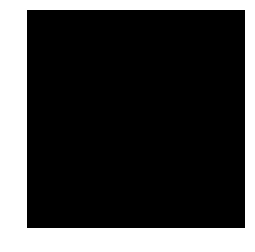

In [16]:
use_hill=True;N=10;theta=0.5
x0 = X0_test[y_test==3][1000]
grad = grad_score(x0,True,N,theta,mlp_orig)
plt.imshow(grad.reshape(28,28),cmap=plt.cm.gray)
plt.axis('off');plt.show()

[0.99974438]
[0.99967377]
[0.99958719]
[0.99950201]
[0.99943272]
[0.9993761]
[0.99932715]
[0.99928423]
[0.99924613]
[0.99921094]
[0.99917637]
[0.99913971]
[0.9990965]
[0.99903809]
[0.99895625]
[0.99886442]
[0.99875223]
[0.99852028]
[0.99830909]
[0.99825342]
[0.9982097]
[0.99815806]
[0.9980618]
[0.99777888]
[0.99733757]
[0.99723265]
[0.997112]
[0.99689509]
[0.99675982]
[0.99656834]
[0.9958072]
[0.99295332]
[0.99285109]
[0.99279339]
[0.99274333]
[0.99268482]
[0.99257579]
[0.99196339]
[0.98923573]
[0.98825682]
[0.98464329]
[0.98453565]
[0.98435471]
[0.98365773]
[0.96918899]
[0.97395546]
[0.94493904]
[0.84103246]
[0.87014672]


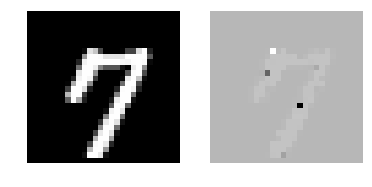

In [21]:
x0 = X0_test[y_test==7][1000]
x1,num_iter = iter_grad(x0,True,10,theta,mlp_orig,5)
fig,ax = plt.subplots(1,2)
ax[0].imshow(x0.reshape(28,28),cmap=plt.cm.gray)
ax[1].imshow(x1.reshape(28,28),cmap=plt.cm.gray)
# ax[2].imshow(hill(x.reshape(28,28),N,theta),cmap=plt.cm.gray)

[a.axis('off') for a in ax]
plt.show()

0.0


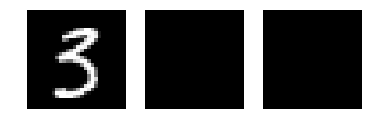

0.0


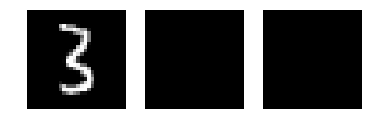

0.012667277681188005


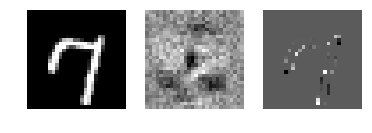

9.840516831621779e-05


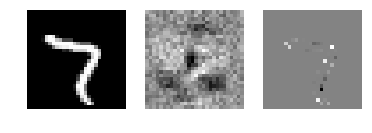

0.0


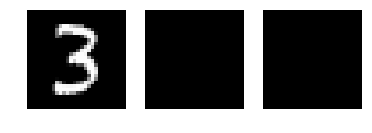

0.00027002782387235


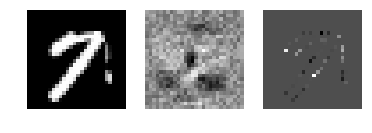

0.00861044320971547


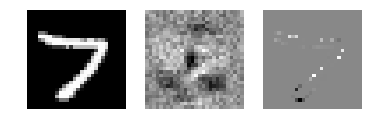

0.24654179781750057


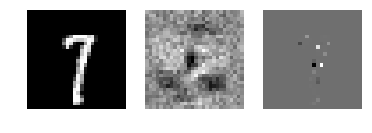

0.0


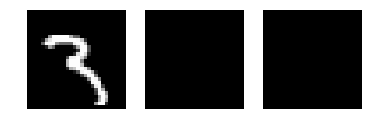

0.24477775807868357


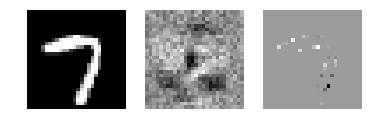

In [22]:
sample = [int(len(X0_test)*random.random()) for _ in range(10)]

for i in sample:
    x = X0_test[i]
    grad_xF = grad_score(x,False,0,0,mlp_orig)
    print(sum(grad_xF**2))
    grad_xT = grad_score(x,True,10,0.5,mlp_orig)
    fig,ax = plt.subplots(1,3)
    ax[0].imshow(x.reshape(28,28),cmap=plt.cm.gray)
    ax[1].imshow((grad_xF).reshape(28,28),cmap=plt.cm.gray)
    ax[2].imshow((grad_xT).reshape(28,28),cmap=plt.cm.gray)
    [a.axis('off') for a in ax]
    plt.show()
# print(grad)

In [34]:
print(score(x,False,0,0,mlp_orig))
print(y_test[num])

[0.01646657]
3.0


3.0
0


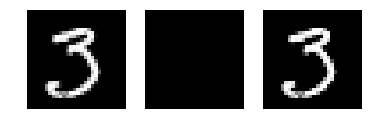

In [40]:
num = 1360
eps = 0.5
use_hill = True
N = 2
theta = 0.8
x = X0_test[y_test == 3][num].copy()
pred = y_test[y_test == 3][num]
# pred = score(x,use_hill,N,theta,mlp_orig)
print(pred)
num_iter = 0
# while pred == y_test[num]:
while pred < 0.98:
    print(score(x,use_hill,N,theta,mlp_orig))
    grad = grad_score(x,use_hill,N,theta,mlp_orig)
    if y_test[num] == 3:
        x += eps*grad[:]
    elif y_test[num] == 7:
        x -= eps*grad[:]
#     pred = mlp_orig.predict(x.reshape(1,-1))
    pred = score(x,use_hill,N,theta,mlp_orig)
    num_iter += 1
print(num_iter)
fig,ax = plt.subplots(1,3)
ax[0].imshow(X0_test[y_test == 3][num].reshape(28,28),cmap=plt.cm.gray)
ax[1].imshow(grad.reshape(28,28),cmap=plt.cm.gray)
ax[2].imshow(hill(x.reshape(28,28),N,theta),cmap=plt.cm.gray)
[a.axis('off') for a in ax]
plt.show()

2 [4.]


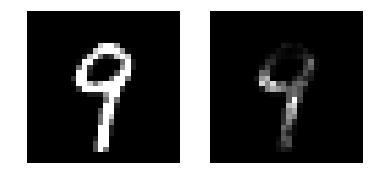

6 [4.]


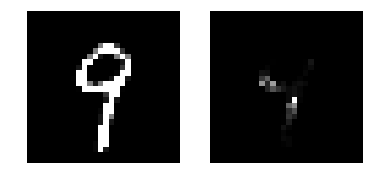

10 [4.]


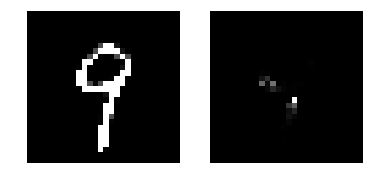

14 [4.]


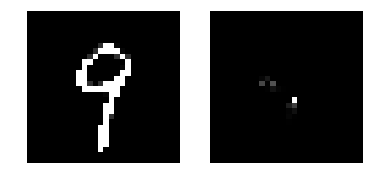

18 [4.]


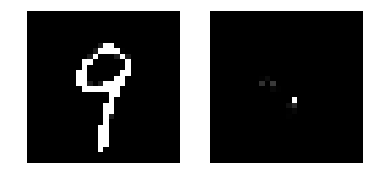

22 [4.]


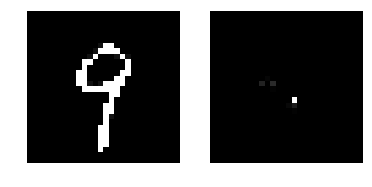

26 [4.]


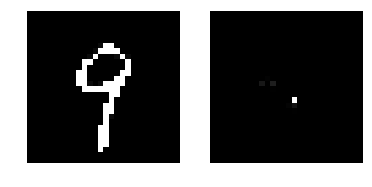

In [588]:
for i in np.arange(2,30,4):
    y = hill(x.reshape(1,-1),i,theta)
    print(i, mlp_orig.predict(y))
    fig,ax = plt.subplots(1,2)
    ax[0].imshow(hill(X0_test[num].reshape(28,28),i,theta),cmap=plt.cm.gray)
    ax[1].imshow(y.reshape(28,28),cmap=plt.cm.gray)
    [a.axis('off') for a in ax]
    plt.show()

[760, 406, 638, 1045, 322]
[0.99771786]
[0.99979101]
[0.97157543]
[0.9999972]
[0.99999471]


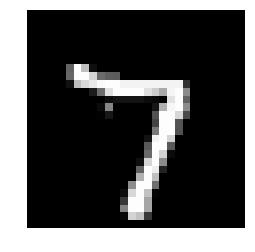

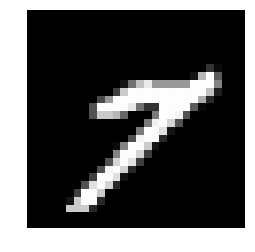

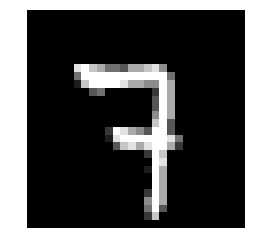

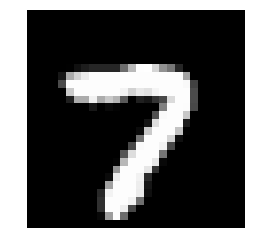

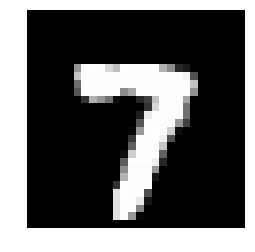

In [109]:
sample = [int(len(X0_test[y_test == 7])*random.random()) for _ in range(5)]
print(sample)
score7 = [print(score(X0_test[y_test == 7][i],False,0,0,mlp_orig)) for i in sample]
for i in sample:
    x = X0_test[y_test == 7][i]
    plt.imshow(x.reshape(28,28),cmap=plt.cm.gray)
    plt.axis('off')
    plt.show()

In [141]:
N = 2; theta = 0.8
sample = [1359, 189, 1314, 366, 1129, 1045]
epsilon = np.arange(0.2,1.2,0.2)
num_iter_table = [np.zeros((len(sample),len(epsilon)))]*2

for i,x in enumerate(X0_test[y_test==7][sample]):
    for j,eps in enumerate(epsilon):
        num_iter_table[0][i,j] = iter_grad(x,7,False,N,theta,mlp_orig,eps)
        num_iter_table[1][i,j] = iter_grad(x,7,True,N,theta,mlp_orig,eps)
pprint(num_iter_table[0])
pprint(num_iter_table[1])

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])
array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])
